In [4]:
import os
from Tinder import tinder_api
from Tinder import fb_auth_token
import cv2
import urllib
import urllib.request
import uuid
import json

import numpy as np
from IPython.display import clear_output

from matplotlib import pyplot as plt
%matplotlib inline

from mtcnn.mtcnn import MTCNN
detector = MTCNN()
import uuid


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [5]:
import os, shutil
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

In [6]:
resource_root = 'D:/resources/tinder/'
# Enter your facebook email 
fb_username = 'nemesgyadam@gmail.com'
# Enter your facebook password 
fb_password = '!sadi007007'


fb_access_token = fb_auth_token.get_fb_access_token(fb_username, fb_password)
fb_user_id = fb_auth_token.get_fb_id(fb_access_token)
tinder_api.get_auth_token(fb_access_token, fb_user_id)

You have been successfully authorized!


'7921c7d5-1471-44ad-b09f-4ce0ad7a6506'

In [7]:
def findFaces(photos, path, score_threshold=0.9, size_threshold=1000):
    print('[INFO] Detecting faces...')
    os.mkdir(os.path.join(path))
    for photo in photos:
        try:
            for face in detector.detect_faces(photo):
                x, y, w, h = face['box']
                score = face['confidence']

                if h*w > size_threshold and score > score_threshold:
                    face=photo[y:y+h, x:x+w]
                    cv2.imwrite(os.path.join(path,str(uuid.uuid4())+'.jpg'), face)
        except Exception as e:
            print(e)

In [8]:
def downloadImgs(photos,  rows = 2, cols = 3):

    downloaded_images = []
    for i, photo in enumerate(photos):
        img_url = photo['processedFiles'][0]['url']
        req = urllib.request.urlopen(img_url)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr, -1) # 'Load it as it is'
        
        downloaded_images.append(img)
      
    return downloaded_images

def showImgs(photos, name, rows = 2, cols =3, clear = True):
    fig = plt.figure(figsize=(15, 10))
    for i, photo in enumerate(photos):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(cv2.cvtColor(photo, cv2.COLOR_BGR2RGB))
        plt.title(name)
        if i == (rows*cols)-1:
            break
    if clear:
        clear_output(wait=True)
    plt.show()


def saveProfile(imgs, res, status = 'unlabeled'):
    print('[INFO] Saving profile...')
    try:
        columns_to_drop = ['content_hash','photos', 'ping_time', 's_number']
        for column in columns_to_drop:
            res.pop(column)
        path = os.path.join(resource_root, status, res['_id'])
        os.mkdir(path)
        os.mkdir(os.path.join(path,'photos'))
        with open(os.path.join(path,'bio.json'), 'w') as fp:
            json.dump(res, fp)

        for i, img in enumerate(imgs):
            cv2.imwrite(os.path.join(path,'photos','{}.jpg'.format(uuid.uuid4())), img)

        findFaces(imgs,os.path.join(path, 'faces'))
    except Exception as e:
        print(e)
    

In [9]:
def downloadRecommandations():
    print('[INFO] Downloading recommandations...')
    recommendations = tinder_api.get_recommendations()
    downloaded = os.listdir(os.path.join(resource_root, 'unlabeled'))

    new = 0
    for res in recommendations['results']:
        
        if not res['_id'] in downloaded:
            imgs = downloadImgs(res['photos'])
            #showImgs(imgs, res['name'])
            saveProfile(imgs, res)
            new += 1

    print(f'[INFO] {new} new profiles downloaded')
    return new

found = True
while found:
    found = downloadRecommandations() > 0

[INFO] Downloading recommandations...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] 3 new profiles downloaded
[INFO] Downloading recommandations...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] 3 new profiles downloaded
[INFO] Downloading recommandations...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] Saving profile...
[INFO] Detecting faces...
[INFO] 9 new profiles downloaded
[INFO] Downloading rec

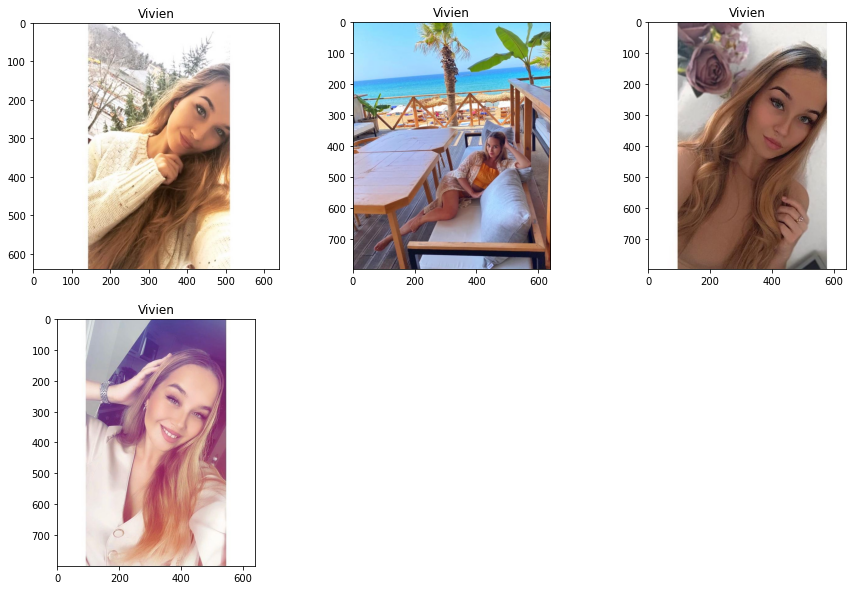

[INFO] Detecting faces...


In [64]:
#MIMIC NORMAL TINDER USAGE
recommendations = tinder_api.get_recommendations()
for res in recommendations['results']: 
    
    imgs = showImgs(res['photos'],res['name'])
   
    if input('Y/N?').lower() == 'y':
        saveProfile(imgs, res, 'liked')
        tinder_api.like(res['_id'])
    else:
        saveProfile(imgs, res, 'disliked')
        tinder_api.dislike(res['_id'])
    

Separate downloaded images

In [13]:
def loadImages(id, category, folder = 'photos'):
    images = []
    for file in os.listdir(os.path.join(resource_root, category, id, folder)):
        images.append(cv2.imread(os.path.join(resource_root, category, id, folder, file)))
    return images


def showProfile(id, category = 'unlabeled'):
    photos = loadImages(id, category)
    

    f = open (os.path.join(resource_root, category, id, 'bio.json' ), "r")
    bio = json.loads(f.read())
    
    showImgs(photos, id)
    try:
        face  = loadImages(id, category, 'faces')
        showImgs(face, id, clear = False)
    except:
        print("No faces found")
    print(bio['bio'])

downloaded =  os.listdir(os.path.join(resource_root, 'unlabeled'))


def like(id, forReal = False):
    shutil.move(os.path.join(resource_root, 'unlabeled', id), os.path.join(resource_root, 'liked', id))
    if forReal:
        tinder_api.like(res['_id'])


def dislike(id, forReal = False):
    shutil.move(os.path.join(resource_root, 'unlabeled', id), os.path.join(resource_root, 'disliked', id))
    if forReal:
        tinder_api.dislike(res['_id'])


def separate():
    for i, id in enumerate(downloaded):
        showProfile(id)
        if input('Y/N?').lower() == 'y':
            like(id)
        else:
            dislike(id)
    

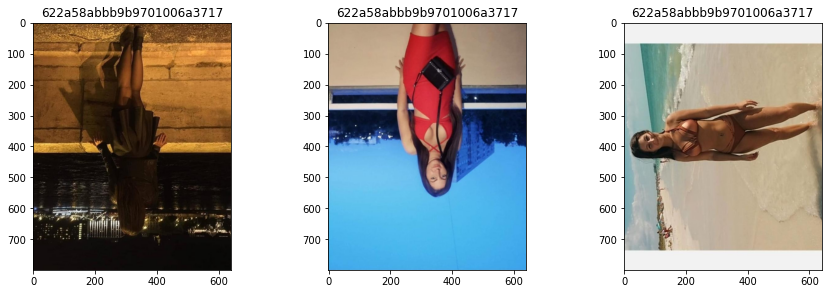

No faces found
Rólam?
Elcsavarom a fejedet... 😄🙆‍♀️


In [14]:
separate()

In [20]:
def copyFiles2TrainFolder():
    target_root = 'C:/Code/TINDER/resources/faces/nemes'
    target = {
        'liked': '+'
        ,'disliked': '-'
    }
    for category in ['liked', 'disliked']:
        for id in os.listdir(os.path.join(resource_root, category)):
            try:
                for face in os.listdir(os.path.join(resource_root, category, id, 'faces')):
                    shutil.copy(os.path.join(resource_root, category, id, 'faces', face), os.path.join(target_root,target[category], face))
            except:
                print(f'No faces found for {id}')

In [21]:
copyFiles2TrainFolder()

No faces found for 620d35292ad29e01005bcd9e
No faces found for 551c49754710549f28554e20
No faces found for 5f54e422cfd1d50100fddd4c
No faces found for 622a58abbb9b9701006a3717
